# Reproducibility of steady-states data

**Author:** M.G. Baltussen & T.J. de Jong

**Estimated running time:** 2 minutes

**Generated output:**
```
plots_extended/steadystates_reproducibility.{svg,png}
```

In [1]:
""" System imports """
import pathlib
import toml

""" Essential imports"""
import numpy as np
import pandas as pd

""" ML/RC imports """
from sklearn.feature_selection import mutual_info_regression as mi_reg
from sklearn import linear_model, model_selection, preprocessing, svm
from sklearn import metrics

from pyrcn.echo_state_network import ESNClassifier


""" Visualization imports and settings"""
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.7, 
rc={
    "axes.linewidth": 0.5,     
    'axes.facecolor':'#eceff4', 
    'axes.edgecolor':'#2e3440',
    'axes.labelcolor':'#2e3440',
    'text.color': '#2e3440',
    'xtick.color': '#2e3440',
    'ytick.color': '#2e3440',
    'font.family': 'Arial',
    'svg.fonttype': 'none',
    })
import colorcet as cc

nord_palette = [
    "#bf616a","#d08770","#ebcb8b","#a3be8c","#b48ead",
    "#8fbcbb","#88c0d0","#81a1c1","#5e81ac",
    "#2e3440","#3b4252","#434c5e","#4c566a",
    "#d8dee9","#e5e9f0","#eceff4",
]

sns.set_palette(nord_palette)

def save_plot(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots/{name}.svg", **kwargs)
    plt.savefig(f"../plots/{name}.png", dpi=600, **kwargs)

def save_si(name, **kwargs):
    """Helper function to save figures in desired formats and location"""
    plt.savefig(f"../plots_extended/{name}.svg", **kwargs)
    plt.savefig(f"../plots_extended/{name}.png", dpi=600, **kwargs)


In [2]:
df_all = pd.read_csv("../data/steadystates.csv", index_col=0)

label_map = pd.read_csv("../data/compound_label_map.csv",names=["compound","composition"])

label_dict = dict(zip(label_map["compound"],label_map["composition"]))
df_all = df_all.rename(columns=label_dict)


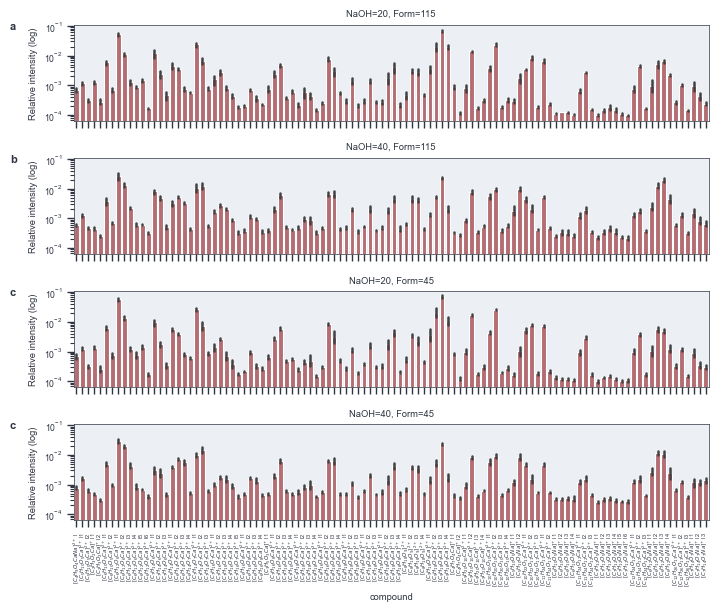

In [3]:
conditions = [(20, 115), (40, 115), (20, 45), (40, 45)]

fig, axes = plt.subplots(4, 1, figsize=(7.087, 6), sharex=True, sharey=True, constrained_layout=True, gridspec_kw={'hspace': 0.1})

axes = axes.flatten()

for idx, conc in enumerate(conditions):
    filtered_data = df_all.query("NaOH==@conc[0] and Form==@conc[1]").drop(columns=['time', 'NaOH', 'Form'])
    
    ax = axes[idx]
    
    sns.barplot(data=filtered_data, ax=ax, color='C0')
    
    ax.set_yscale("log")
       
    ax.set_title(f'NaOH={conc[0]}, Form={conc[1]}')
    ax.set_ylabel("Relative intensity (log)")
    ax.set_xlabel("")
axes[3].set_xlabel("compound")
plt.xticks(rotation=90, size=4)

axes[0].text(-0.1, 0.95, "a", transform=axes[0].transAxes, size=8, weight="bold")
axes[1].text(-0.1, 0.95, "b", transform=axes[1].transAxes, size=8, weight="bold")
axes[2].text(-0.1, 0.95, "c", transform=axes[2].transAxes, size=8, weight="bold")
axes[3].text(-0.1, 0.95, "c", transform=axes[3].transAxes, size=8, weight="bold")

save_si("steadystates_reproducibility")
plt.show()
